In [46]:
import json
import os
import math
import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in os.listdir(game_path):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in games:
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



Loaded 10600 games.
Unique players: 84321


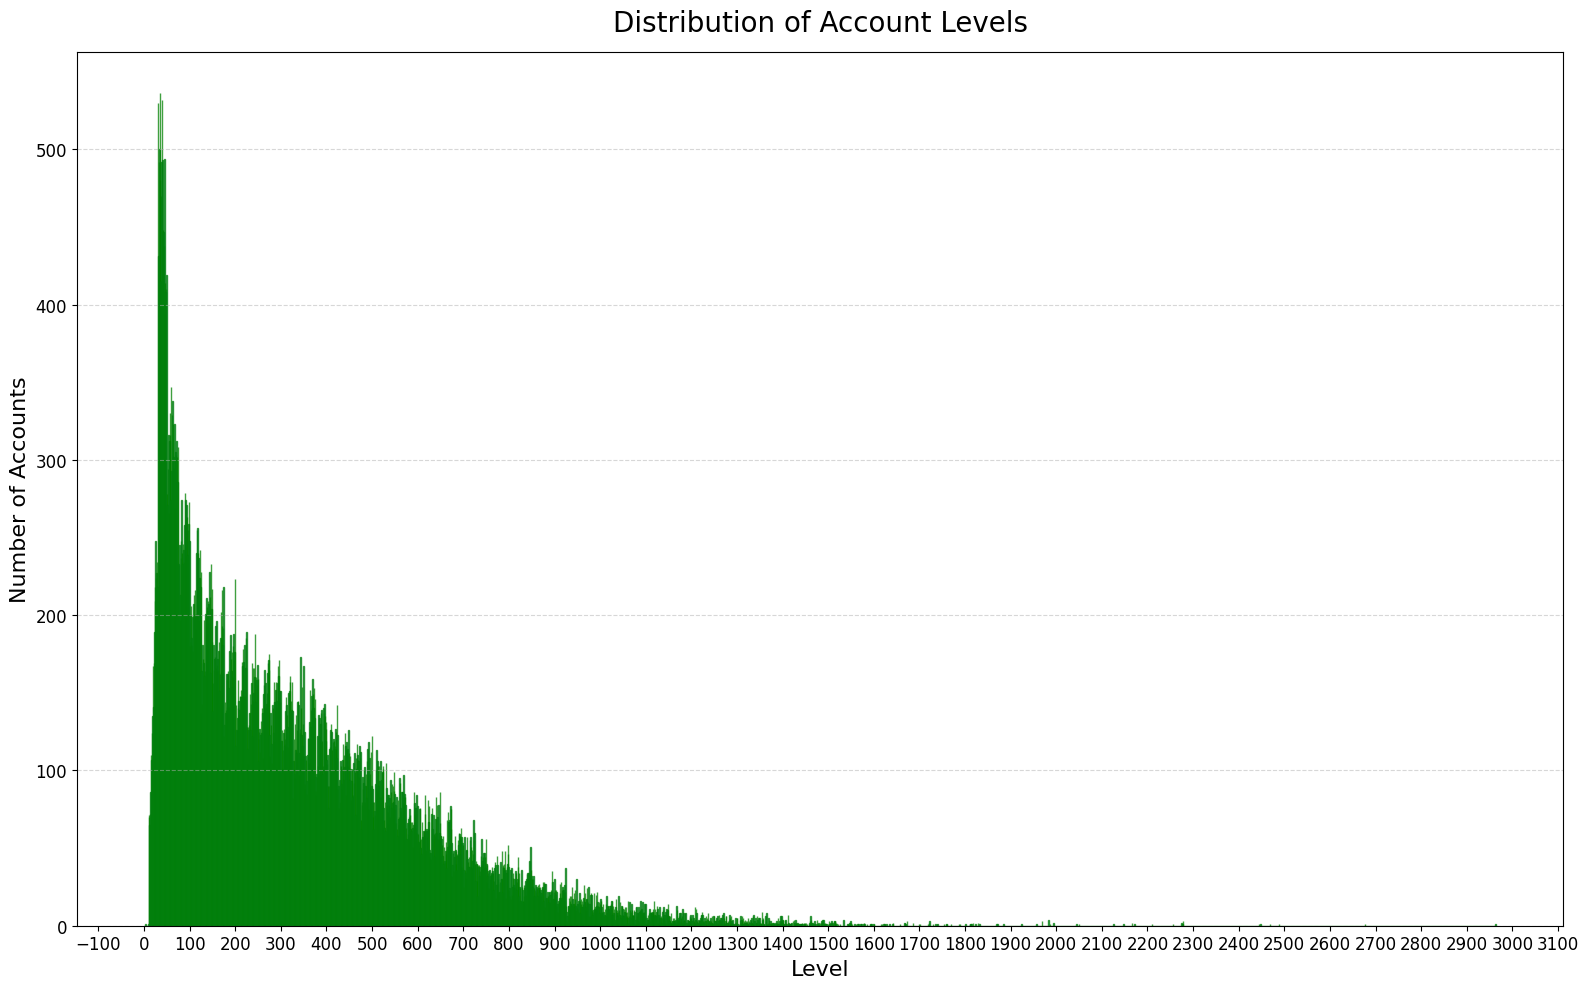

"Qnoxs #17165" Level: 2963
0.5264811490125674


In [52]:
def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

        

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_percentage_of_surrendered_games(games: dict) -> float:
    surrendered_games = 0
    for game in games:
        s = game.get("info").get("participants", [])[0]["gameEndedInSurrender"]
        es = game.get("info").get("participants", [])[0]["gameEndedInEarlySurrender"]
        if s == True or es == True:
            surrendered_games += 1
    return surrendered_games/len(games)

def get_team_champion_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("champExperience", 0))
        else:
            team2_levels.append(participant.get("champExperience", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_team_min_max_level(game: dict) -> tuple:
    team1_max_level = 0
    team1_min_level = math.inf
    team2_max_level = 0
    team2_min_level = math.inf

    for p in game.get("info").get("participants", []):
        if p.get("teamId") == 100:
            if p.get("summonerLevel", 0) > team1_max_level:
                team1_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team1_min_level:
                team1_min_level = p.get("summonerLevel", 0)
        if p.get("teamId") == 200:
            if p.get("summonerLevel", 0) > team2_max_level:
                team2_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team2_min_level:
                team2_min_level = p.get("summonerLevel", 0)
    return ((team1_min_level, team1_max_level), (team2_min_level, team2_max_level))

def higher_absolute_level_winrate(games:list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_max_level = 0
    won_with_lower_max_level = 0

    for game in games:
        l = get_team_min_max_level(game)
        team1_min_level, team1_max_level = l[0]
        team2_min_level, team2_max_level = l[1]
        team1_win = False
        team2_win = False

        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True

        if team1_max_level > team2_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_higher_max_level += 1
            if team2_win:
                won_with_lower_max_level += 1

        if team2_max_level > team1_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_lower_max_level += 1
            if team2_win:
                won_with_higher_max_level += 1
    return won_with_higher_max_level/all_games

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def higher_champion_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_champion_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    print(f"{won_with_higher_level} Wins with higher champion level and {won_with_lower_level} Wins with lower champion level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level

plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

print(higher_level_winrate(games, 200))


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]


[0.5093894498442956, 0.5090509050905091, 0.5080576759966073, 0.5085014735887554, 0.5079961230918343, 0.5095360824742268, 0.5129663014838441, 0.513183375539997, 0.5159736715363622, 0.51421143847487, 0.5162131941856131, 0.5152253349573691, 0.5142478462557986, 0.5112872238232469, 0.5115002613695766, 0.5124108416547789, 0.5101277656590838, 0.5094210346008907, 0.5116366366366366, 0.5170151701517015, 0.5264811490125674, 0.5238329238329238, 0.5261472785485592, 0.5201421800947867, 0.5201037613488976, 0.518978102189781, 0.5185185185185185, 0.5215479331574319, 0.5356435643564357, 0.5420765027322404, 0.5460122699386503, 0.5480378890392422, 0.5475113122171946, 0.5577889447236181, 0.5617977528089888, 0.5592515592515592, 0.5496535796766744, 0.5487179487179488, 0.5502958579881657, 0.5335570469798657, 0.5300751879699248, 0.5504201680672269, 0.5529953917050692, 0.5691489361702128, 0.5748502994011976, 0.5608108108108109, 0.5692307692307692, 0.5517241379310345, 0.5392156862745098, 0.5617977528089888, 0.5

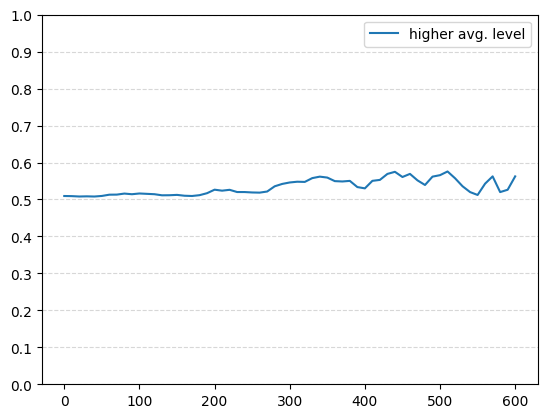

In [48]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_level_winrate(games, d)
    winrates_higher.append(wr)
    winrates_lower.append(lower_level_winrate(games, d))
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher avg. level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]


[0.5094891889340005, 0.5098990683229814, 0.5114168910160535, 0.5117852018856323, 0.5126147999577747, 0.5135810517166449, 0.5149445874846076, 0.5157566662818885, 0.5152020984857517, 0.5153344007882744, 0.5149586250795671, 0.51648495993695, 0.5148797390949857, 0.5144825646794151, 0.5160490224686315, 0.5166062801932367, 0.5162856248042593, 0.5183322517845554, 0.5194150277357539, 0.519317786286112, 0.519877123238164, 0.520868425977915, 0.5217136150234741, 0.5224398204814361, 0.519373279695109, 0.5190873189995612, 0.51993583868011, 0.5194650107475519, 0.5174825174825175, 0.5187775187775188, 0.5193861066235864, 0.5190194420963652, 0.5186709791237871, 0.5195360195360196, 0.5176807900605288, 0.5208193418401612, 0.5194123819517313, 0.5230769230769231, 0.5238278247501922, 0.5217566478646253, 0.5212990299451709, 0.5217582417582417, 0.5223948811700183, 0.5235350624399616, 0.5250501002004008, 0.523784355179704, 0.528071150639244, 0.5252760023242301, 0.5229357798165137, 0.5215157353885678, 0.5191403

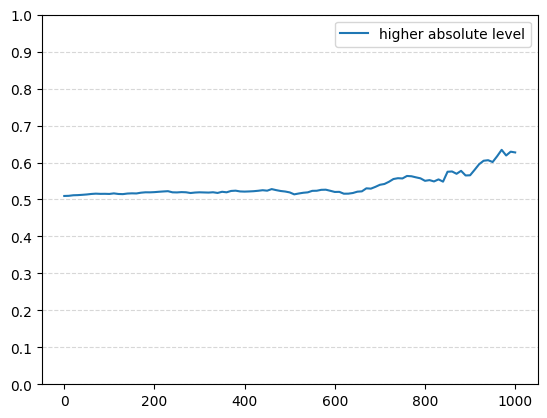

In [49]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_absolute_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
10172 Wins with higher champion level and 415 Wins with lower champion level of 10587 games
9963 Wins with higher champion level and 337 Wins with lower champion level of 10300 games
9854 Wins with higher champion level and 304 Wins with lower champion level of 10158 games
9779 Wins with higher champion level and 280 Wins with lower champion level of 10059 games
9699 Wins with higher champion level and 257 Wins with lower champion level of 9956 games
9611 Wins with higher champion level and 229 Wins with lower champion level of 9840 games
9509 Wins with higher champion level and 205 Wins with lower champion level of 97

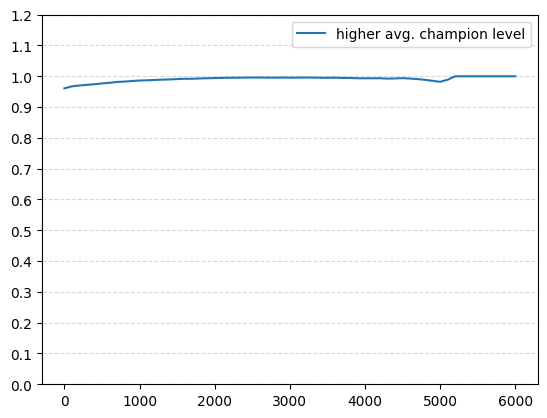

In [50]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [53]:
print(get_percentage_of_surrendered_games(games))

0.3013207547169811
